<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Efficient-Frontier" data-toc-modified-id="Efficient-Frontier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Efficient Frontier</a></span><ul class="toc-item"><li><span><a href="#Minimum-variance-line" data-toc-modified-id="Minimum-variance-line-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Minimum variance line</a></span><ul class="toc-item"><li><span><a href="#Theoretical-development" data-toc-modified-id="Theoretical-development-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Theoretical development</a></span></li><li><span><a href="#Function-for-calculating-the-minimum-variance-line" data-toc-modified-id="Function-for-calculating-the-minimum-variance-line-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Function for calculating the minimum variance line</a></span></li><li><span><a href="#Function-for-visualising-the-minimum-variance-and-efficient-frontier" data-toc-modified-id="Function-for-visualising-the-minimum-variance-and-efficient-frontier-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Function for visualising the minimum variance and efficient frontier</a></span></li><li><span><a href="#Example-with-sample-data" data-toc-modified-id="Example-with-sample-data-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Example with sample data</a></span></li></ul></li></ul></li></ul></div>

# Efficient Frontier

In [1]:
import numpy as np
import sympy as sy
from scipy import stats
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objs as go
from tqdm.notebook import tqdm
tqdm.pandas()

## Minimum variance line

### Theoretical development

If the expected return $\mu$ is given, there exists a portfolio's expected return $\mu_V=\mu$ and variance $\sigma_V < \sigma_{V'}$ for all the attainable portfolios $V'$ with $\mu_{V'}=\mu$. For $\mu \in \mathbb{R}$, such set of the portfolio ($\mu_V$, $\sigma_V$) form the minimum variance line, or the minimum variance frontier.

The portfolio with the smallest variance among attainable portfolios with expected return $\mu_V$ has weights:

\begin{equation}
    w = \frac{\lambda_1}{2}mC^{-1}+\frac{\lambda_2}{2}uC^{-1},
\end{equation}
where
\begin{equation}
    \begin{bmatrix} \lambda_1 \\\ \lambda_2 \end{bmatrix}=2\begin{bmatrix}mC^{-1}m^{T} & uC^{-1}m^{T} \\\ mC^{-1}u^{T} & uC^{-1}u^T\end{bmatrix}^{-1}\begin{bmatrix}\mu \\\ 1 \end{bmatrix}.
\end{equation}

$w$ is the $n$ array of portfolio weights. $m$ is the $n$ array of stock returns. $u$ is a $n$ array of 1. $C$ is the $n \times n$ covariance matrix of the portfolio. 

\begin{proof}

For $\mu \in \mathbb{R}$, to get the minimum variance $wCw^T$ subject to (1) $wm^T=\mu$ and (2) $wu^T=1$, we take
    
\begin{equation*}
    G(w, \lambda_1, \lambda_2) = wCw^T- \lambda_1(wm^T-\mu)-\lambda_2(wu^T-1),
\end{equation*}

where $\lambda$ and $\mu$ are Lagrange multipliers. The partial derivatives of $G$ with respect to the weights $w_i$, $\mu1$, and $\mu2$ equated to zero give the necessary conditions for a minimum:

\begin{equation*}
    2wC - \lambda_1m - \lambda_2u = 0 \\\
    wm^T - \mu = 0 \\\
    wu^T - 1 =0
\end{equation*}

The first equation implies:

\begin{equation*}
    2w = \lambda_1mC^{-1}+\lambda_2uC^{-1}
\end{equation*}

Substituting this into the other two constraints, we obtain a system of linear equations

\begin{equation*}
    \lambda_1mC^{-1}m^T+\lambda_2uC^{-1}m^T=2\mu \\\
    \lambda_1mC^{-1}u^T+\lambda_2uC^{-1}u^T=2,
\end{equation*}

and the coefficients matrix can be written as

\begin{equation*}
    M = \begin{bmatrix} mC^{-1}m^T & uC^{-1}m^T \\\ mC^{-1}u^T & uC^{-1}u^T \end{bmatrix}.
\end{equation*}

Then we can solve the $\lambda_1$ and $\lambda_2$:

\begin{equation*}
    \begin{bmatrix} \lambda_1\\\ \lambda_2 \end{bmatrix} = 2M^{-1}\begin{bmatrix} \mu\\\ 1 \end{bmatrix}.
\end{equation*}

\end{proof}


### Function for calculating the minimum variance line

**Description of** `calMVL(eRetList, stdList, corrList, portERet, printFormula= False, returnType="weightList")`:

The function takes the portfolio's stock returns, standard deviations, and correlation list, then calculate the portfolio weights for the minimum variance line. **If the expected portfolio is given**, the function will return can be minimum variance weights list (`returnType="weightList"`, default), print minimum variance portfolio return, variance and weights (`returnType="fullPrint"`), or return a dictionary of the portfolio return and variance (`returnType="dictionary"`). **If the expected portfolio return is unknown**, the function can print the mean-variance formula of minimum variance line (`printFormula=True`, default is `False`), and return the list of the coefficients ("constant", "return-linear coefficient", and "return-quadratic coefficient").

**Arguments**
<a id="calMVP"></a>

- `eRetList`, `stdList`, `corrList`: like what we did before, these three parameters are lists of stock returns, standard deviations, and correlations. The correlation list should follow the combination order from smaller distance between $i$ and $j$ to larger, for example, if $n = 4$:

\begin{bmatrix}
    \rho_{12} & \rho_{23} & \rho_{34} & \rho_{13} & \rho_{24} & \rho_{14}
\end{bmatrix}

- `portERet`: if the entry is a number representing the expected portfolio return, such as 0.2, the output can be weight list `returnType="weightList"`, full print of the calculation (`returnType="fullPrint"`), or a dictionary storing the results (`returnType="dictionary"`). If the entry is `None`, the function can print the formula for minimum variance line (printFormula=True) and return the list of coefficients (power increasing order).

In [2]:
def calMVL(eRetList, stdList, corrList, portERet, printFormula=False, returnType="weightList"):
    
    CovMat = []
    n = len(stdList)
    calMVL.n = n
    u = np.array([1] * n)
    for x in range(1,n+1):
        Cxy = []
        for y in range(1,n+1):
            if x == y:   
                Cxy.append(stdList[x-1]**2)
            elif x < y:
                idx = int((y-x-1)*n-(((y-x)*(y-x-1))/2)+x)
                Cxy.append(corrList[idx-1]*stdList[x-1]*stdList[y-1])
            elif x > y:
                idx = int((x-y-1)*n-(((x-y)*(x-y-1))/2)+y)
                Cxy.append(corrList[idx-1]*stdList[x-1]*stdList[y-1])
        CovMat.append(Cxy)
    
    calMVL.CovMat = CovMat
    M = [[np.dot(np.dot(np.array(eRetList),np.linalg.inv(CovMat)),np.array(eRetList).transpose()),
          np.dot(np.dot(u,np.linalg.inv(CovMat)),np.array(eRetList).transpose())],
         [np.dot(np.dot(np.array(eRetList),np.linalg.inv(CovMat)),u.transpose()),
          np.dot(np.dot(u,np.linalg.inv(CovMat)),u.transpose())]]
    MInverse = np.linalg.inv(M)
    
    if portERet:
        ePortRet2 = np.array([portERet,1]).transpose()
        lamb1 = np.dot(MInverse,ePortRet2)[0]
        lamb2 = np.dot(MInverse,ePortRet2)[1]
        
        weightArray = lamb1*np.dot(eRetList,np.linalg.inv(CovMat))+lamb2*np.dot(u,np.linalg.inv(CovMat))
        weightList = list(weightArray)

        portVar = np.dot(np.dot(weightList, CovMat), np.array(weightList).transpose())
        if returnType == "weightList":
            return weightList
        elif returnType == "fullPrint":
            weightRound = list(np.round(weightArray,3))
            print("Condition: the expected portfolio return is %s" % round(portERet, 4))
            print("The minimum variance weights are: %s, sum to %s" % (weightRound, int(np.sum(weightArray))))
            print("The portfolio's variance is %s" % round(portVar,4))
            try:
                print("The portfolio's standard deviation is %s" % round(np.sqrt(portVar),4))
            except:
                pass
        elif returnType == "dictionary":
            volaDict = dict()
            volaDict["return"] = portERet
            volaDict["variance"] = portVar

            return volaDict
        
    else:
        x, y = sy.symbols('x y')
        ePortRet2 = sy.Matrix([[y],[1]])
        MLamb = sy.Matrix(MInverse)*sy.Matrix(ePortRet2)
        lamb1 = MLamb[0]
        lamb2 = MLamb[1]
        weightArray = lamb1*sy.Matrix(eRetList).transpose()*sy.Inverse(sy.Matrix(CovMat))\
                      +lamb2*sy.Matrix(u).transpose()*sy.Inverse(sy.Matrix(CovMat))
        calMVL.weightArray = weightArray
        portVar = weightArray*sy.Matrix(CovMat)*weightArray.transpose()

        # Calculate MVP for plot
        weightArray_mvp = np.dot(u,np.linalg.inv(CovMat))/np.dot(np.dot(u,np.linalg.inv(CovMat)),u.transpose())
        weightList_mvp = list(weightArray_mvp)
        portERet_mvp = np.dot(np.array(weightList_mvp), np.array(eRetList).transpose())
        portVar_mvp = np.dot(np.dot(weightList_mvp, CovMat), np.array(weightList_mvp).transpose())
        calMVL.portERet_mvp = portERet_mvp
        calMVL.portVar_mvp = portVar_mvp
        
        formula_left = sy.simplify(portVar[0])
        formula = sy.Poly(formula_left - x**2)
        by2 = formula.coeffs()[1]
        by1 = formula.coeffs()[2]
        cons = formula.coeffs()[3]
        
        if printFormula:
            strFormula = "The frontier is: σ\u00b2 = %s + %sμ + %sμ\u00b2" %(round(cons,3),round(by1,3),round(by2,3))
            print(strFormula.replace("+ -", "- "))
        else:
            pass
        coeffList = [cons, by1, by2]
        return coeffList


**If the expected portfolio return is given**, i.e. the parameter entry of `portERet` is a number, `calMVL` will return for the portfolio with conditional minimum variance either the list of weights (`returnType="weightList"`, by default), or a dictionary containing the return and variance (`returnType = "dictionary"`), or just print the return, weights, variance and standard deviation (`returnType = "fullPrint"`). 

In [3]:
eRetList = [0.2, 0.13, 0.17]
stdList = [0.25, 0.28, 0.2]
corrList = [0.3, 0, 0.15]
portERet = 0.2

calMVL(eRetList, stdList, corrList, portERet, returnType="fullPrint")

Condition: the expected portfolio return is 0.2
The minimum variance weights are: [0.722, -0.208, 0.486], sum to 0
The portfolio's variance is 0.0444
The portfolio's standard deviation is 0.2107


**If the expected portfolio is not given**, i.e. the parameter entry is `False`, `calMVL` will compute the formula of the **minimum variance line** with "y" as the expected return and "x" as the standard deviation. 

If keyword argument `printFormula=True` (by default is `False`), `calMVL` will print the formula of the minimum variance line and return a list of coefficients, which are "constant", "y-linear coefficient", and "y-quadratic coefficient".

In [4]:
eRetList = [0.1, 0.15, 0.2]
stdList = [0.28, 0.24, 0.25]
corrList = [-0.1, 0.2, 0.25]
portERet = False 

calMVL(eRetList, stdList, corrList, portERet, printFormula=True)

The frontier is: σ² = 0.237 - 2.885μ + 9.851μ²


[0.237392428474999, -2.88543916091178, 9.85134389116777]

**Three securities visualisation (type 1): using two weights as parameters**

There are two convenient ways to visualise all portfolios that can be constructed from the three securities. The following cell provide the first one using two of the three weights, $w_2$ and $w_3$, as parameters. The remaining weight $w_1=1-w_2-w_3$. The three points of the blue triangle are three situations where the portfolio only has one stock with 100% weight. The blue sides of the triangle represent the situation where the portfolio only contains two stocks. Points inside of the triangle, including the boundaries, represent the situation without short selling. The minimum variance line is the orange line with the equation printed above the figure. Here, the minimum variance line is linear because the linear relationship between the expected portfolio return and weights.

The minimum variance line is: w₃ = -0.361w₂ + 2.050
The remaining weight w₁ = 1 - w₂ - w₃


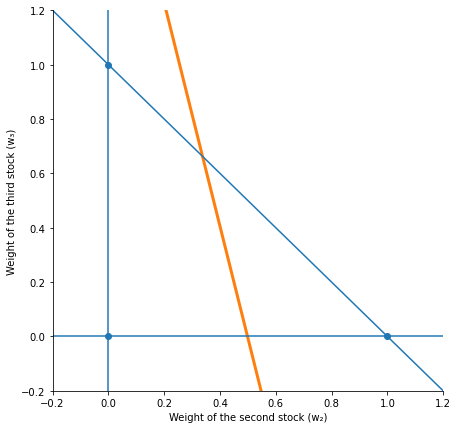

In [5]:
w2, w3, y = sy.symbols("w2 w3 y")
eqw2 = sy.Eq(calMVL.weightArray[1], w2)
eqw3 = sy.Eq(calMVL.weightArray[2], w3)
eqw2w3 = sy.Poly(sy.simplify(sy.solve(eqw2, y)[0]-sy.solve(eqw3, y)[0]))
strEq = "w\u2083 = %sw\u2082 + %s" %(round(eqw2w3.coeffs()[0],3), round((eqw2w3.coeffs()[2])/(-eqw2w3.coeffs()[1]),3))
print("The minimum variance line is: "+ strEq.replace("+ -", "- "))
print("The remaining weight w\u2081 = 1 - w\u2082 - w\u2083")

f = plt.figure(figsize=(7, 7))
ax = f.add_subplot(1, 1, 1)

x = np.linspace(-0.2, 1.2, 100)
y = (eqw2w3.coeffs()[0]*x + eqw2w3.coeffs()[2])/(-eqw2w3.coeffs()[1])
y1 = 1 - x
plt.plot(x, y, color=list(mcolors.TABLEAU_COLORS.values())[1], lw=3)
plt.plot(x, y1, color=list(mcolors.TABLEAU_COLORS.values())[0])
plt.scatter([0,0,1],[0,1,0])
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.axhline(0, color=list(mcolors.TABLEAU_COLORS.values())[0])
plt.axvline(0, color=list(mcolors.TABLEAU_COLORS.values())[0])
plt.xlabel("Weight of the second stock (w\u2082)")
plt.ylabel("Weight of the third stock (w\u2083)")

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()
# f.savefig("w1w2_plane.pdf", bbox_inches="tight")


**Description of** `simulate_weights(repetition, eRetList, stdList, corrList, shortSelling=False, plotScatter=False)`

Like what we did, the function takes the portfolio's return list, standard deviation list and correlation list, then generates random weights for `repetition` times. These weights are used to calculate portfolio's return and standard deviation for plot. The return can be a sample scatter of the standard deviation and the expected return, or a pandas DataFrame containing the standard deviation, the expected return, the efficiency measure ($\frac{\mu}{\sigma}$), and the weight for the second security (the reason will be explained later).

**Arguments**

- `repetition`: number of times for the random weight simulation. 10,000 times would return a pretty good plot.
- `shortSelling=False`: default is `False`, which means the weights will only be randomly generated within 0 to 1. If `True`, the weights will be generate following the standard normal distribution, then adjusted to sum to 1.
- `plotScatter=False`: default is `False`, which will return a  a pandas DataFrame containing the standard deviation, the expected return, the efficiency measure ($\frac{\mu}{\sigma}$), and the weight for the second security. If `True`, the function will generate a scatter of the standard deviation and return. However, the `plotScatter=True` is only used inside our later function for visualisation.

In [6]:
def simulate_weights(repetition, eRetList, stdList, corrList, shortSelling=False, plotScatter=False):
        portERet = False 
        calMVL(eRetList, stdList, corrList, portERet)
        random_list = []
        times = 1
        while times < repetition:
            random_dict = dict()
            if shortSelling:
                weight_rand = np.array(1 + 1 * np.random.randn(calMVL.n))
            else:
                weight_rand = np.array(np.random.random(calMVL.n))
            weight_rand_list = list(weight_rand/np.sum(weight_rand))
            portERet_rand = np.dot(np.array(weight_rand_list), np.array(eRetList).transpose())
            portVar_rand = np.dot(np.dot(weight_rand_list, calMVL.CovMat), np.array(weight_rand_list).transpose())
            portSD_rand = np.sqrt(portVar_rand)
            random_dict["Return"] = portERet_rand
            random_dict["Standard deviation"] = portSD_rand
            random_dict["Efficiency"] = (portERet_rand) * (1/portSD_rand)
            random_dict["Weight2"] = weight_rand_list[1]
            random_list.append(random_dict)
            times += 1
        df_random = pd.DataFrame(random_list)
        if plotScatter:
            if shortSelling:
                plt.scatter("Standard deviation", "Return", data=df_random, c="grey", marker="1", alpha=0.1)
            else:
                plt.scatter("Standard deviation", "Return", data=df_random, c="Efficiency", alpha=0.1)
        else:
            return df_random


**Three securities visualisation (type 2): the Markowitz bullet**

First, we can set the weight simulation for 10,000 times, the generate an interactive scatter using `plotly`. The graph is sometimes called the risk–expected return graph, and the shape is called **the Markowitz bullet**. 

The first scatter represents the similar shape of all the attainable portfolios **without considering short selling**, which are the combinations of the three securities (orange diamonds). The lighter the color, the more efficient the portfolio is.

The second scatter **allows short selling** with outliers winsorised, and the sphere of the attainable portfolio becomes much wider, but still form the minimum variance line in bullet shape.

In [7]:
df_random = simulate_weights(10000, eRetList, stdList, corrList, shortSelling=False, plotScatter=False)

In [25]:
fig = px.scatter(df_random, x="Standard deviation", y="Return", color="Efficiency")

fig.add_trace(go.Scatter(x=stdList, y=eRetList, mode='markers',
                         marker=dict(
                             color='Orange',
                             symbol='diamond',
                             size=12,
                             line=dict(
                                 color='MediumPurple',
                             width=2
                             )
                         ),
                         showlegend=True, name='Individual stock'))

fig.update_layout(legend=dict(x=0, y=1))
fig.update_traces(hovertemplate="<br>".join(["Return: %{y}","Standard deviation: %{x}"]))
dictFig = fig.to_dict()
dictFig["data"][0]["type"] = "scatter"
fig = go.Figure(dictFig)
fig.show()
# fig.write_html("plotly_scatter_no_short.html")
# fig.write_image("plotly_scatter_no_short.pdf")

In [9]:
df_random2 = simulate_weights(10000, eRetList, stdList, corrList, shortSelling=True, plotScatter=False)
df_random2 = df_random2[(np.abs(stats.zscore(df_random2["Standard deviation"])) < 0.2)]

In [26]:
fig = px.scatter(df_random2, x="Standard deviation", y="Return", color="Efficiency")
fig.add_trace(go.Scatter(x=stdList, y=eRetList, mode='markers',
                         marker=dict(
                             color='Orange',
                             symbol='diamond',
                             size=12,
                             line=dict(
                                 color='MediumPurple',
                             width=2
                             )
                         ),
                         showlegend=True, name='Individual stock'))

fig.update_layout(legend=dict(x=0, y=1))
fig.update_traces(hovertemplate="<br>".join(["Return: %{y}","Standard deviation: %{x}"]))
dictFig = fig.to_dict()
dictFig["data"][0]["type"] = "scatter"
fig = go.Figure(dictFig)
fig.show()
# fig.write_html("plotly_scatter_with_short.html")
# fig.write_image("plotly_scatter_with_short.pdf")

**Transformation: $w_2$-$w_3$ triangle to the Markowitz bullet**

It is instructive to imagine how the above $w_2$-$w_3$ triangle is transformed into the risk–expected Markowitz bullet. The triangle is folded along the minimum variance line, being warped and stretched to attain the shape of the Markowitz bullet. 

And here is the reason for the function `simulate_weights()` to return the weight of the second security in the DataFrame. The weight of the second security ($w_2$) is the additional dimension in the 3D interactive scatter below. Thus, we can clearly observe how the portfolio is formed from the three securities, how the $w_2$-$w_3$ triangle is warped and stretched into the Markowitz bullet, and how it display the bullet shape in the risk–expected 2D scatter. Because in three dimension, it is a bullet!

In [12]:
df_random3d = simulate_weights(10000, eRetList, stdList, corrList, shortSelling=False, plotScatter=False)

In [28]:
fig = px.scatter_3d(df_random3d, x="Weight2", y="Standard deviation", z="Return", color="Efficiency")

weight2List = [0,1,0]
fig.add_trace(go.Scatter3d(x=weight2List, y=stdList, z=eRetList, 
                           mode='markers',
                           marker=dict(symbol='diamond',
                                       color="cornflowerblue"),
                           showlegend=True, 
                           name='Individual<br>stock'))

fig.update_layout(legend=dict(x=0, y=1))
fig.update_traces(hovertemplate="<br>".join(["Return: %{y}","Standard deviation: %{x}"]))
fig.show()
# fig.write_html("plotly_3dscatter_no_short.html")

### Function for visualising the minimum variance and efficient frontier

**Description of** `frontier_plot(eRetList, stdList, corrList, simulate=(False,False), mBullet=False)`

Like previous function, this function take the portfolio's stock returns, standard deviations and correlation list, and plot the equation of the minimum variance and efficient frontier (in solid blue line). The function also allows the following to appear in the same figure: (1) weight simulation scatter for both situations with and without short selling, and (2) the markowitz bullet line from each of the two securities. 

**Arguments**
<a id="frontier_plot"></a>

- `simulate=(False,False)`: inherently is `simulate=(number1, number2)` (default: False, False). The `number1` randomly picks **positive weights** (from 0 to 1, sum to 1), meaning that **short selling is not allowed**. The `number2` randomly picks weights (either positive or negative, sum to 1) based on the standard normal distribution $N(0,1)$, meaning that **short selling is allowed**

- `mBullet=False`: default is `False`. If `True`, will plot the markowitz bullet line from each of the two securities.


In [14]:
def frontier_plot(eRetList, stdList, corrList, simulate=(False,False), mBullet=False):
    
    f = plt.figure(figsize=(10,8))
    ax = f.add_subplot(1, 1, 1)
    
    portERet = False  
    calMVL(eRetList, stdList, corrList, portERet)
    def MVL_curve(eRetList, stdList, corrList, portERet, printFormula=False, markBullet=False):
        coeffList = calMVL(eRetList, stdList, corrList, portERet)
        cons, by1, by2 = coeffList[0], coeffList[1], coeffList[2]
        strFormula = "The frontier is: σ\u00b2 = %s + %sμ + %sμ\u00b2" %(round(cons,3),round(by1,3),round(by2,3))
        if printFormula==True:
            print(strFormula.replace("+ -", "- "))
    
        x = np.linspace(0, max(stdList)*(4/3), 400)
        y = np.linspace(min(eRetList)-np.abs((2/3)*max(eRetList)), max(eRetList)+np.abs((2/3)*max(eRetList)), 400)
        x, y = np.meshgrid(x, y)

        new_formula = -x**2 + by2*y**2 + by1*y + cons
        maskedUp = y < calMVL.portERet_mvp
        maskedDown = y > calMVL.portERet_mvp
        if markBullet:
            plt.contour(x, y, new_formula, [0], linestyles='-', colors='orange', linewidths=0.8)

#             plt.contour(np.ma.masked_where(maskedUp,x), np.ma.masked_where(maskedUp,y), np.ma.masked_where(maskedUp,new_formula), [0], linestyles='-', colors='orange', linewidths=0.8)
#             plt.contour(np.ma.masked_where(maskedDown,x), np.ma.masked_where(maskedDown,y), np.ma.masked_where(maskedDown,new_formula), [0], linestyles='-', colors='orange', linewidths=0.8)
        else:
            plt.contour(np.ma.masked_where(maskedUp,x), np.ma.masked_where(maskedUp,y), np.ma.masked_where(maskedUp,new_formula), [0], colors='deepskyblue', linestyles='-', linewidths=2)
            plt.contour(np.ma.masked_where(maskedDown,x), np.ma.masked_where(maskedDown,y), np.ma.masked_where(maskedDown,new_formula), [0], colors='deepskyblue', linestyles='--', linewidths=2)
    
    MVL_curve(eRetList, stdList, corrList, portERet, printFormula=True, markBullet=False)
    
    if simulate[1]:
        simulate_weights(simulate[1], eRetList, stdList, corrList, shortSelling=True, plotScatter=True)
    if simulate[0]:
        simulate_weights(simulate[0], eRetList, stdList, corrList, shortSelling=False, plotScatter=True)
        
    plt.scatter(stdList, eRetList, color="orange", alpha=0.7)
    plt.scatter(np.sqrt(np.abs(calMVL.portVar_mvp)), calMVL.portERet_mvp, marker='v', color="red")

    if mBullet:
        for distance in range(1, len(eRetList)):
            i = 1
            next_i = i + distance
            while next_i <= len(eRetList):
                ret_new = [eRetList[i-1], eRetList[next_i-1]]
                std_new = [stdList[i-1], stdList[next_i-1]]
                corr_idx = (np.abs(i-next_i)-1)*len(eRetList)-((i-next_i)**2-np.abs(i-next_i))/2+min(i,next_i)-1
                corr_new = [corrList[int(corr_idx)]]               
                MVL_curve(ret_new, std_new, corr_new, portERet, markBullet=mBullet)     
                i += 1
                next_i = i + distance
    
    plt.xlim([0, max(stdList)*(4/3)])
    plt.ylim([min(eRetList)-np.abs((2/3)*max(eRetList)), max(eRetList)+np.abs((2/3)*max(eRetList))])
    plt.xlabel("Standard Deviation (σ)")
    plt.ylabel("Expected Return (μ)")
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.show()

#     f.savefig("ef_%s.pdf" % np.random.random(1), bbox_inches='tight')


With only three entries, `frontier_plot` can generate a plot of standard deviation and return including the scatter of individual stocks (orange dots), the global minimum variance portfolio (red marker), and the minimum variance line (blue solid line is the efficient frontier).

The frontier is: σ² = 0.237 - 2.885μ + 9.851μ²


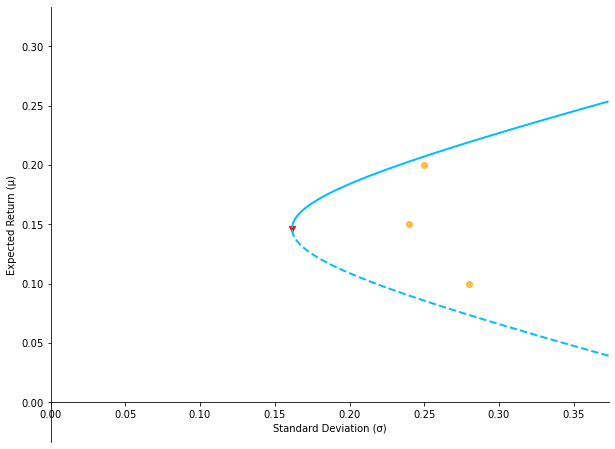

The frontier is: σ² = 0.237 - 2.885μ + 9.851μ²


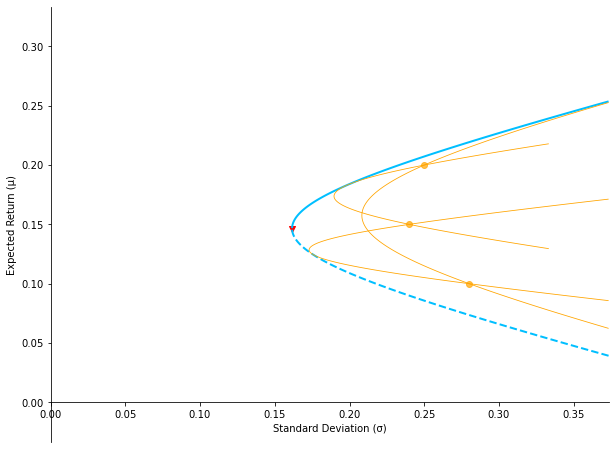

In [15]:
frontier_plot(eRetList, stdList, corrList, mBullet=False)
frontier_plot(eRetList, stdList, corrList, mBullet=True)

Furthurmore, we can set the number of random simulations for portfolio weights and plot the scatter of these mean-variance pairs, by adding number of random simulations to the keyword argument `simulate=(number1, number2)` (default: False, False). The `number1` randomly picks **positive weights** (from 0 to 1, sum to 1), meaning that **short selling is not allowed**. The `number2` randomly picks weights (either positive or negative, sum to 1) based on the standard normal distribution $N(0,1)$, meaning that **short selling is allowed**.

For instance: 

1. `simulate=(10000,False)` will only plot 10,000 randomly weighted **portfolios with positive weights**. The lighter the color, the more efficient the portfolio is.

2. `simulate=(False,10000)` will only plot 10,000 randomly weighted **portfolios with positive or negative weights**, considering the short selling exists.

3. `simulate=(10000,10000)` will plot 10,000 randomly weighted **portfolios with positive weights** in color gradients, and 10,000 randomly weighted **portfolios with positive or negative weights** in grey.

The frontier is: σ² = 0.237 - 2.885μ + 9.851μ²


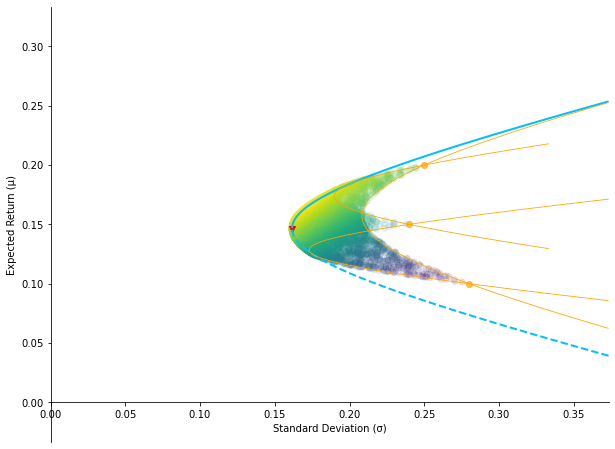

The frontier is: σ² = 0.237 - 2.885μ + 9.851μ²


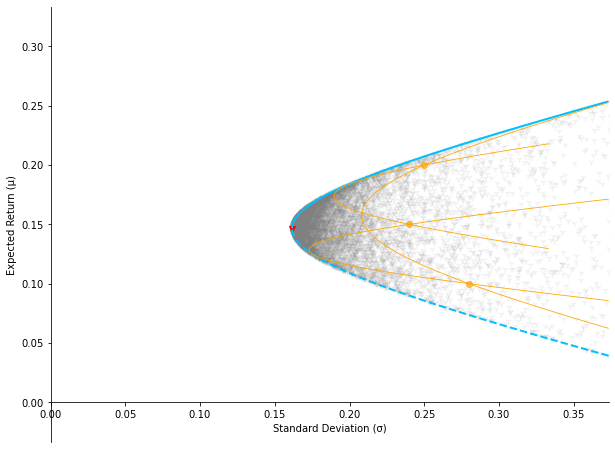

The frontier is: σ² = 0.237 - 2.885μ + 9.851μ²


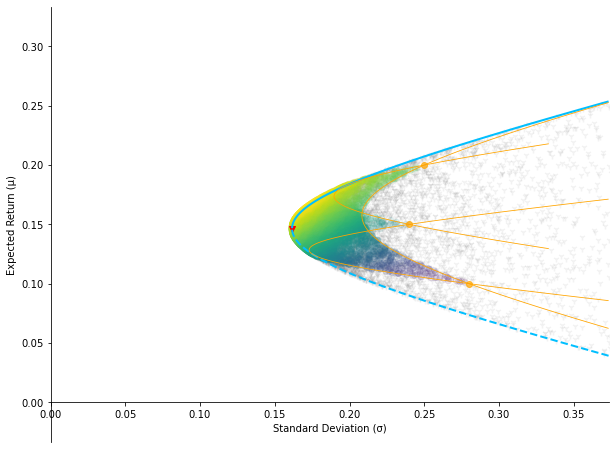

In [16]:
frontier_plot(eRetList, stdList, corrList, simulate=(10000,False), mBullet=True)
frontier_plot(eRetList, stdList, corrList, simulate=(False,10000), mBullet=True)
frontier_plot(eRetList, stdList, corrList, simulate=(10000,10000), mBullet=True)

### Example with sample data

**Description of** `calSampleMVL(n_sample, dataframe, portERet=False, returnType="weightList", symPlot=True, simulate=(False,False), mBullet=False)`

This function can do all the works of previous functions, whether calculating minimum variance weights or equation, or generate line graph for the equation and simulation scatter, but with real world data.

**Arguments**

- `n_sample` (type: int): number of sample that are randomly selected from the data set. If exceed the index range of data set, `n_sample` will equal the length of the data set minus 10 (or equal 1 if still out of index range).
- `dataframe` (type: Pandas DataFrame). Below is an example DataFrame using the 30 industry portfolios monthly return data (June 2017 - April 2022) from Fama French library by `pandas_datareader`.
- `portERet=False` and `returnType="weightList"`: see [`calMVL()`](#calMVP).
- `symPlot=True`: if `True` (default), will return the plot. If `False`, will return minimum variance weights (when `portERet` has assigned a value) or the formula of minimum variance line (`portERet=False`, default).
- `simulate=(False,False)`, `mBullet=False`: see [`frontier_plot()`](#frontier_plot).


In [17]:
def calSampleMVL(n_sample, dataframe, portERet=False, returnType="weightList", symPlot=True, simulate=(False,False), mBullet=False):
    df = dataframe 
    if n_sample < len(df.columns) and n_sample > 0:
        num = n_sample
    else:
        try:
            num = len(df.columns) - 10
        except:
            num = 1
        print("[Error] number out of range. Plot default sample.")
    
    df_sample = pd.concat([df["yrm"], df.loc[:,df.columns!="yrm"].sample(n=num,axis='columns',replace=False)], axis=1)
    corrList = []
    for distance in range(1, len(df_sample.columns)-1):
        i = 1
        next_i = i + distance
        while next_i <= len(df_sample.columns)-1:
            correlation = df_sample[df_sample.columns[i]].corr(df_sample[df_sample.columns[next_i]])
            corrList.append(correlation)
            i += 1
            next_i = i + distance
    eRetList = [df_sample[df_sample.columns[i]].mean() for i in range(1, len(df_sample.columns))]
    stdList = [df_sample[df_sample.columns[i]].std() for i in range(1, len(df_sample.columns))]
    if portERet:
        return calMVL(eRetList, stdList, corrList, portERet, returnType=returnType)
    else:
        if symPlot:
            return frontier_plot(eRetList, stdList, corrList, simulate=simulate, mBullet=mBullet)
        else:
            return calMVL(eRetList, stdList, corrList, portERet=False, printFormula=True)
  

In [18]:
df = pdr.DataReader('30_Industry_Portfolios', 'famafrench')[0].progress_apply(lambda x: x*0.01)
df["yrm"] = df.index
df

  0%|          | 0/30 [00:00<?, ?it/s]

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other,yrm
Date,,,,,,,,,,,,,,,,,,,,,
2017-06,-0.0271,-0.0114,-0.0094,-0.0014,0.0276,-0.0015,0.0955,0.0554,0.0199,0.0157,...,-0.0064,-0.0348,0.0193,0.0344,0.0021,-0.0241,-0.0245,0.0584,0.0133,2017-06
2017-07,0.0158,0.0125,-0.0599,0.0505,0.0238,0.0186,0.0122,0.0070,0.0109,0.0221,...,0.0412,0.0309,-0.0235,-0.0444,-0.0091,0.0098,-0.0229,0.0191,0.0149,2017-07
2017-08,-0.0271,0.0103,-0.0087,-0.0169,-0.0631,0.0035,-0.0521,0.0258,0.0161,0.0125,...,0.0146,0.0510,0.0081,0.0067,-0.0430,-0.0176,0.0144,-0.0122,0.0161,2017-08
2017-09,0.0052,-0.0291,-0.0204,0.0375,0.0360,-0.0013,0.0112,0.0205,0.0668,0.0013,...,0.0062,0.0099,0.0254,0.0633,0.0469,0.0275,0.0044,0.0522,0.0107,2017-09
2017-10,0.0077,0.0133,-0.0281,0.0208,-0.0185,-0.0278,0.0301,-0.0227,0.0563,0.0541,...,0.0620,0.0710,0.0437,-0.0189,-0.0077,0.0330,0.0386,0.0339,-0.0119,2017-10
2017-11,0.0426,0.0441,0.0142,0.0337,0.1023,0.0493,0.0744,0.0246,0.0223,0.0756,...,0.0017,0.0251,0.0429,0.0672,0.0369,0.0942,0.0562,0.0393,0.0167,2017-11
2017-12,-0.0001,0.0440,0.0496,0.0086,0.0111,0.0236,0.0458,-0.0017,0.0058,-0.0223,...,0.0047,-0.0077,-0.0086,0.0283,0.0429,0.0255,0.0133,0.0105,0.0123,2017-12
2018-01,0.0236,-0.0011,0.0013,0.1726,0.0440,-0.0197,0.0729,0.0637,0.0170,0.0160,...,0.0931,0.0540,0.0438,0.0268,0.0481,0.1156,0.0277,0.0616,0.0557,2018-01
2018-02,-0.0676,-0.0676,-0.0662,0.0109,-0.0322,-0.0627,-0.0195,-0.0353,-0.0512,-0.1235,...,-0.0168,0.0209,-0.0528,-0.0666,-0.0541,-0.0472,-0.0411,-0.0256,-0.0443,2018-02


In [19]:
portERet = 0.2
calSampleMVL(10, df, portERet, returnType="fullPrint", symPlot=False)

Condition: the expected portfolio return is 0.2
The minimum variance weights are: [-2.313, 4.288, -9.424, -10.191, -7.877, 2.97, 10.641, -4.2, 13.823, 3.284], sum to 1
The portfolio's variance is 0.3364
The portfolio's standard deviation is 0.58


In [20]:
calSampleMVL(10, df, symPlot=False)

The frontier is: σ² = 0.002 - 0.176μ + 7.576μ²


[0.00231063434901240, -0.176171064803407, 7.57623660449877]

The frontier is: σ² = 0.004 - 0.696μ + 46.675μ²


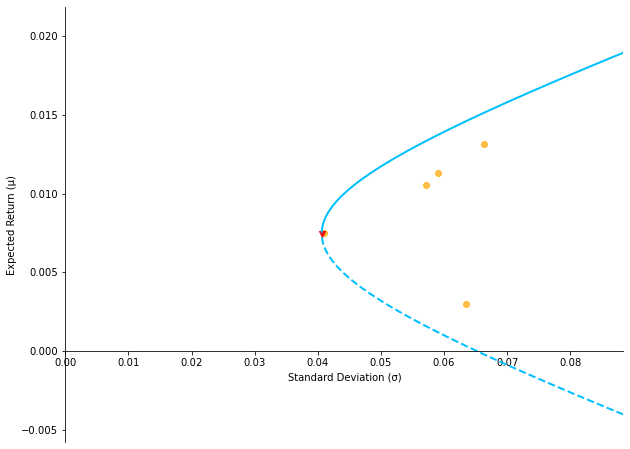

The frontier is: σ² = 0.003 - 0.247μ + 11.317μ²


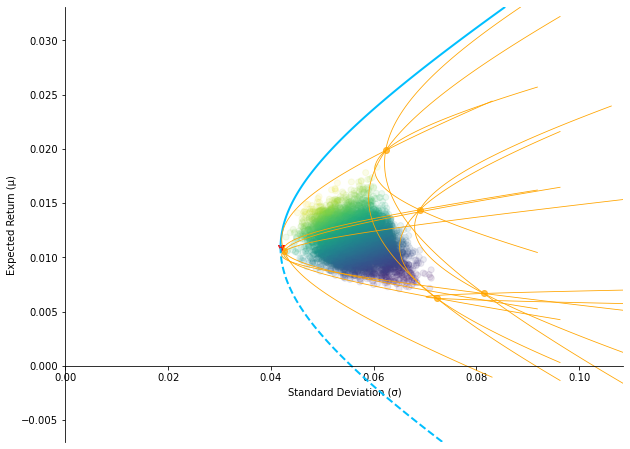

The frontier is: σ² = 0.044 - 10.273μ + 620.085μ²


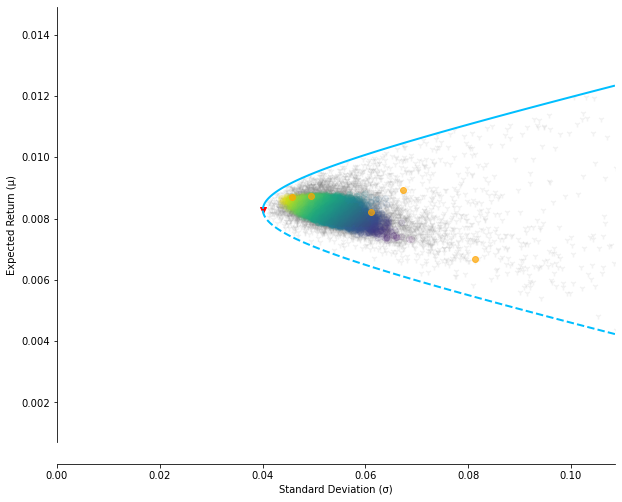

In [21]:
calSampleMVL(5, df, symPlot=True)
calSampleMVL(5, df, symPlot=True, simulate=(10000,False), mBullet=True)
calSampleMVL(5, df, symPlot=True, simulate=(10000,10000), mBullet=False)